In [88]:
import os
import sys
import time
import random
import warnings
import collections
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
import math;
sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# configuration
use_cache = False
# use_cache = True
seed = random.randint(0, 100)
print(f'Seed: {seed}')

mco_id = 1

Seed: 6


<module 'random' from '/usr/lib/python3.8/random.py'>

## ELIGIBILITY & MEMBERSHIP 

In [206]:
query = f"select * from staging.metrics_eligibility where mco_id={mco_id};"
met_elig = cb_utils.sql_query_to_df(query, use_cache=use_cache)

query = f"select * from staging.metrics_members where mco_id={mco_id};"
met_mbrs = cb_utils.sql_query_to_df(query, use_cache=use_cache)


Pulling query from db
Pulling query from db


In [207]:
met_elig[-10:][[ 'id', 'mco_id', 'input_id', 'pct_medicare', 'pct_medicaid', 'file_name', 'n', 'n_product_null', 'min_product', 'max_product', 
                 'n_subproduct_null', 'min_sub_product', 'max_sub_product', 'n_group_null', 'min_group', 'max_group', 
                 'n_subgroup_null', 'min_subgroup', 'max_subgroup', 'n_medicare', 'n_medicaid', 'n_match_lob', 'pct_match_lob', 
                 'min_start_date', 'max_start_date', 'min_end_date', 'max_end_date']]

,id,mco_id,input_id,pct_medicare,pct_medicaid,file_name,n,n_product_null,min_product,max_product,n_subproduct_null,min_sub_product,max_sub_product,n_group_null,min_group,max_group,n_subgroup_null,min_subgroup,max_subgroup,n_medicare,n_medicaid,n_match_lob,pct_match_lob,min_start_date,max_start_date,min_end_date,max_end_date
0,34,1,101,0.00,100.00,agp_eligibility_20200628,10482,0,tn east ltc dual hcbs-dual eligible -adult-ins...,tn east ltc dual hcbs-dual eligible -adult-ins...,0,tn ltc dual-group 2a-hcbs allocation cap-g-l10,tn ltc dual-group 2a-hcbs allocation cap-g-l10,0,tennessee medicaid,tennessee medicaid,0,None,None,0,10482,10482,100.00,2010-03-01,2020-06-26,2017-01-01,2199-12-31
1,36,1,114,0.00,100.00,agp_eligibility_20200628,10482,0,tn east ltc dual hcbs-dual eligible -adult-ins...,tn east ltc dual hcbs-dual eligible -adult-ins...,0,tn ltc dual-group 2a-hcbs allocation cap-g-l10,tn ltc dual-group 2a-hcbs allocation cap-g-l10,0,tennessee medicaid,tennessee medicaid,0,None,None,0,10482,10482,100.00,2010-03-01,2020-06-26,2017-01-01,2199-12-31
2,37,1,114,0.00,86.52,agp_eligibility_20200724,12111,0,dual_product,dual_product,0,tennesee amerivantage specialty,tennesee amerivantage specialty,0,tennessee medicaid,tennessee medicaid,0,None,None,0,10478,10478,86.52,2010-03-01,2020-07-23,2013-04-30,2199-12-31
3,67,1,114,13.52,86.48,agp_eligibility_20200724,12111,0,dual_product,dual_product,0,tennesee amerivantage specialty,tennesee amerivantage specialty,0,-1,-1,0,None,None,1638,10473,12111,100.00,2010-03-01,2020-07-23,2013-04-30,2199-12-31
4,68,1,114,13.52,86.48,agp_eligibility_20200724,12111,0,dual_product,dual_product,0,tennesee amerivantage specialty,tennesee amerivantage specialty,0,-1,-1,0,None,None,1638,10473,12111,100.00,2010-03-01,2020-07-23,2013-04-30,2199-12-31


In [208]:
met_mbrs[['id','mco_id','input_id','file_name','n_no_claims_medical','n_no_claims_rx','nd_source_member_id','n_source_member_id','n_null_source_member_id','n_null_gender','n_null_dod','n_null_dob','n_null_mbi','min_mbi_length','max_mbi_length','min_dod','max_dod','min_dob','max_dob','min_gender','max_gender','created_at']]

,id,mco_id,input_id,file_name,n_no_claims_medical,n_no_claims_rx,nd_source_member_id,n_source_member_id,n_null_source_member_id,n_null_gender,n_null_dod,n_null_dob,n_null_mbi,min_mbi_length,max_mbi_length,min_dod,max_dod,min_dob,max_dob,min_gender,max_gender,created_at
0,34,1,101,agp_eligibility_20200628,543,3832,7130,7130,0,0,0,0,0,9,11,2016-08-03,2020-06-12,1912-08-30,1998-12-24,f,m,2020-07-02 14:41:34.828202
1,36,1,114,agp_eligibility_20200628,3183,7130,7130,7130,0,0,0,0,0,9,11,2016-08-03,2020-06-12,1912-08-30,1998-12-24,f,m,2020-07-29 00:29:22.646349
2,37,1,114,agp_eligibility_20200724,3217,7218,7218,7218,0,0,0,0,0,9,11,2016-08-03,2020-07-12,1912-08-30,1998-12-24,f,m,2020-07-31 20:17:33.361343
3,67,1,114,agp_eligibility_20200724,3217,7218,7218,7218,0,0,0,0,0,9,11,2016-08-03,2020-07-12,1912-08-30,1998-12-24,f,m,2020-08-07 01:06:28.856041
4,68,1,114,agp_eligibility_20200724,3217,7218,7218,7218,0,0,0,0,0,9,11,2016-08-03,2020-07-12,1912-08-30,1998-12-24,f,m,2020-08-07 02:07:47.160546


## Medical Claims

In [210]:
query = f"select * from staging.metrics_claims_medical where mco_id = {mco_id}"
met_claim_medical = cb_utils.sql_query_to_df(query, use_cache=use_cache)

Pulling query from db


### PAID AMOUNT (high, low, n_zero, n_negative, n_null_paid)

In [211]:
met_claim_medical[-10:][['id', 'input_id', 'mco_id','min_paid_amount', 'max_paid_amount', 'n_zero_paid', 'n_negative_paid', 'n_null_paid']]

,id,input_id,mco_id,min_paid_amount,max_paid_amount,n_zero_paid,n_negative_paid,n_null_paid
0,34,102,1,0.0,855705.10,665905,0,0
1,35,116,1,0.0,76877.27,18428,0,0
2,67,116,1,0.0,76877.27,18428,0,0
3,100,116,1,0.0,76877.27,18428,0,0
4,101,116,1,0.0,76877.27,18428,0,0


### HIGHER IS BETTER

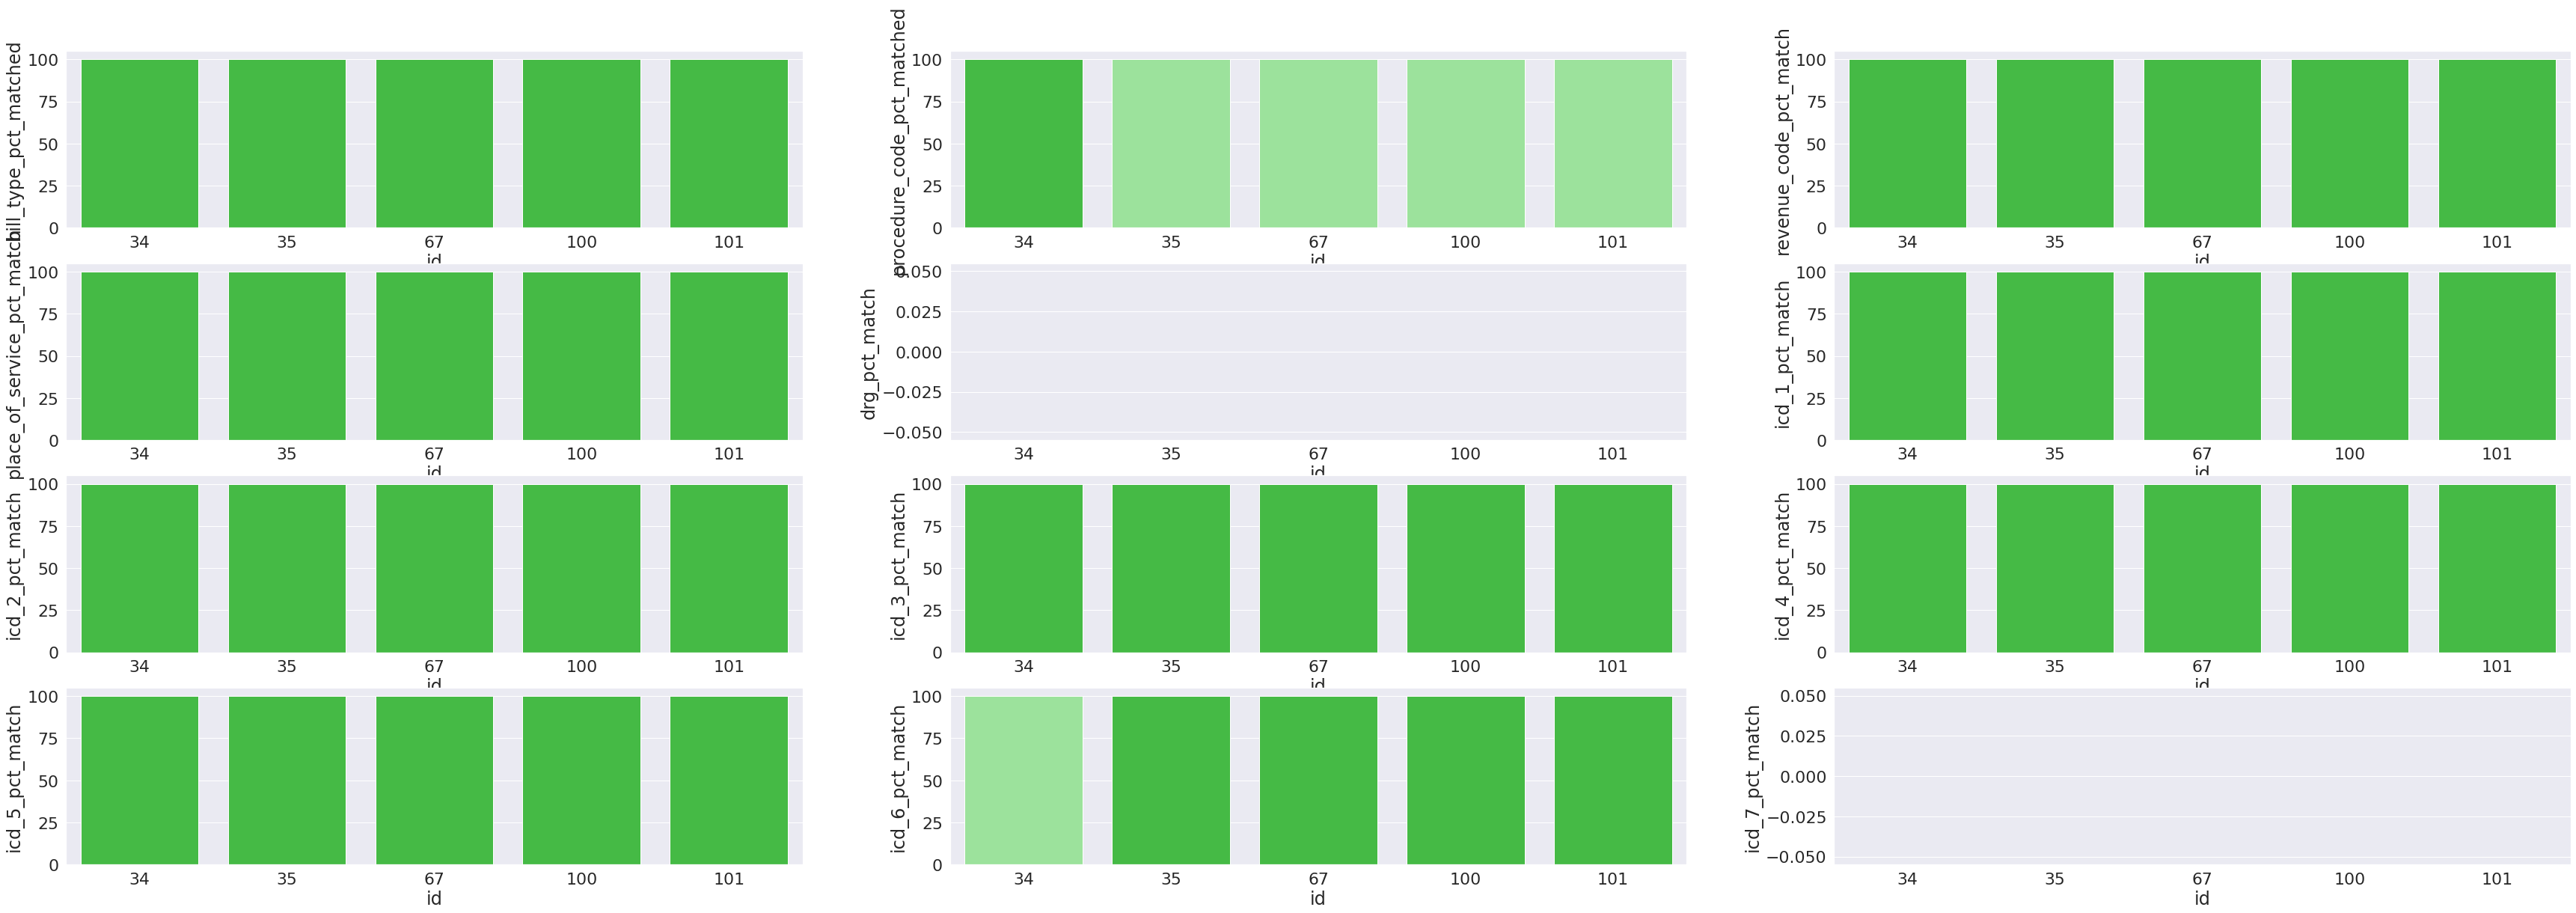

In [212]:
# Higher better
sns.set(font_scale = 2)
col_good_pct = ['bill_type_pct_matched','procedure_code_pct_matched','revenue_code_pct_match',
                'place_of_service_pct_match','drg_pct_match','icd_1_pct_match','icd_2_pct_match',
                'icd_3_pct_match','icd_4_pct_match','icd_5_pct_match','icd_6_pct_match','icd_7_pct_match']

nrows = math.ceil(len(col_good_pct)/3)
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(15 * nrows, 20))

last_10 = met_claim_medical[-10:]
last_10 = last_10.fillna(value=np.nan)

i = 0
for col in col_good_pct:
    l_row = math.floor(i/3)
    l_col = i%3
    clrs = ['lightgreen' if (x < max(last_10[col])) else 'limegreen' for x in last_10[col] ]
    sns.barplot(x='id', y=f'{col}', data=last_10, ax=axs[l_row,l_col], palette=clrs)
    i += 1

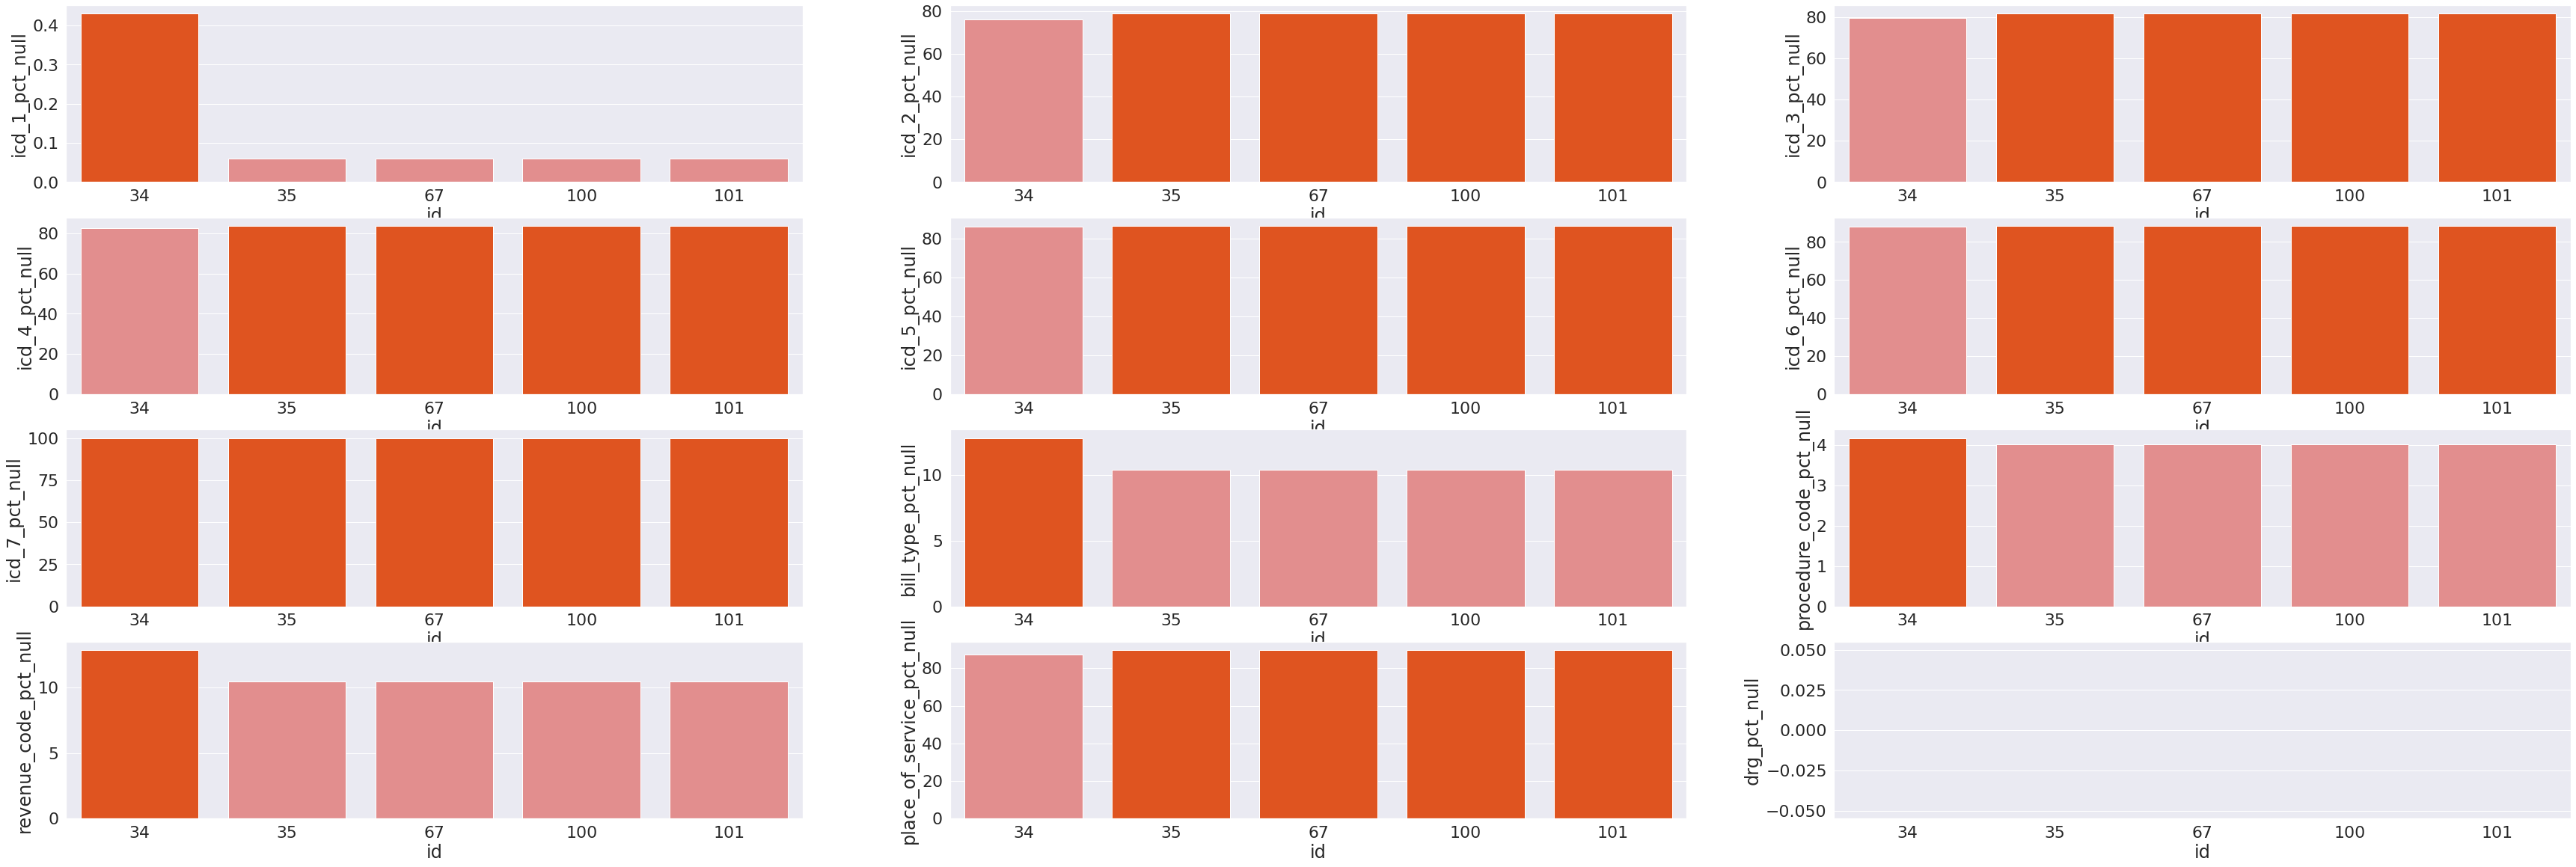

In [213]:
## HIGHER BAD
sns.set(font_scale = 2)
col_bad_pct = [ 'icd_1_pct_null', 'icd_2_pct_null', 'icd_3_pct_null',
 'icd_4_pct_null', 'icd_5_pct_null', 'icd_6_pct_null',
 'icd_7_pct_null', 'bill_type_pct_null', 'procedure_code_pct_null',
  'revenue_code_pct_null', 'place_of_service_pct_null', 'drg_pct_null']

nrows = math.ceil(len(col_good_pct)/3)
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(15 * nrows, 20))

last_10 = met_claim_medical[-10:]
last_10 = last_10.fillna(value=np.nan)

i = 0
for col in col_bad_pct:
    l_row = math.floor(i/3)
    l_col = i%3
    clrs = ['lightcoral' if (x < max(last_10[col])) else 'orangered' for x in last_10[col] ]
    sns.barplot(x='id', y=f'{col}', data=last_10, ax=axs[l_row,l_col], palette=clrs)
    i += 1

## RX CLAIMS 

In [215]:
query = f"select * from staging.metrics_claims_rx where mco_id={mco_id}"
met_claim_rx = cb_utils.sql_query_to_df(query, use_cache=use_cache)

Pulling query from db


In [216]:
display(met_claim_rx[-10:][['min_paid_amount', 'max_paid_amount', 'n_zero_paid']])

,min_paid_amount,max_paid_amount,n_zero_paid
0,-18003.1,39246.63,61164


<AxesSubplot:xlabel='id', ylabel='pct_null_ndc'>

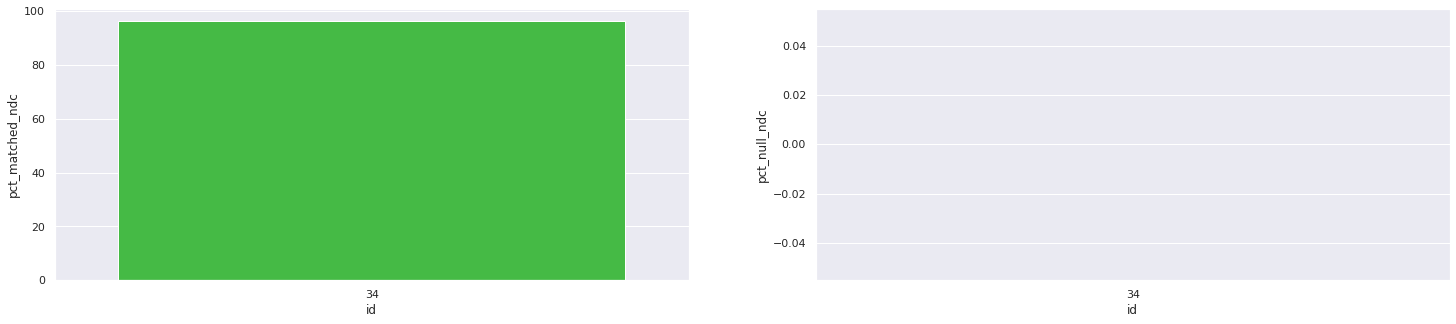

In [217]:
sns.set(font_scale = 1)
fig, axs = plt.subplots(ncols=2, figsize=(25, 5))

last_10 = met_claim_rx[-10:]
last_10 = last_10.fillna(value=np.nan)

col = 'pct_matched_ndc'
clrs = ['lightgreen' if (x < max(last_10[col])) else 'limegreen' for x in last_10[col] ]
sns.barplot(x='id', y=f'{col}', data=last_10, ax=axs[0], palette=clrs)

col = 'pct_null_ndc'
clrs = ['lightcoral' if (x < max(last_10[col])) else 'orangered' for x in last_10[col] ]
sns.barplot(x='id', y=f'{col}', data=last_10, ax=axs[1], palette=clrs)

# TRASH HERE AFTER ----------------------------------------------------------------------

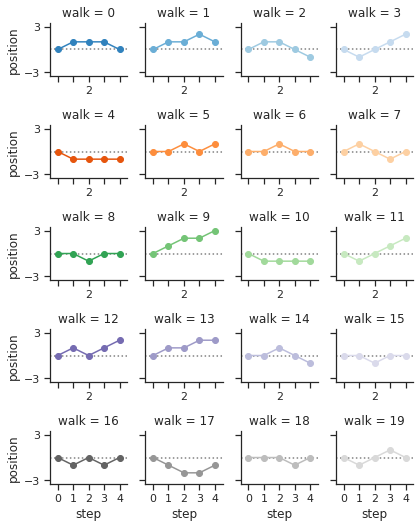

In [12]:
sns.set_theme(style="ticks")

# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)
df = pd.DataFrame(np.c_[pos.flat, step, walk],
                  columns=["position", "step", "walk"])

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="walk", hue="walk", palette="tab20c",
                     col_wrap=4, height=1.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "step", "position", marker="o")

# Adjust the tick positions and labels
grid.set(xticks=np.arange(5), yticks=[-3, 3],
         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

In [26]:
query = f"SELECT dtw.* FROM cb.ds_tall_wide dtw JOIN cb.mcos m ON m.id = {mco_id} AND m.ds_batch_id = dtw.ds_batch_id;"
ds_tall_wide = cb_utils.sql_query_to_df(query, use_cache=use_cache)
ds_tall_wide = ds_tall_wide.drop(columns=['created_at'])
ds_tall_wide.transplant_ddos = [0 if r is None else r for r in ds_tall_wide.transplant_ddos]

Pulling query from db


In [27]:
query = f"SELECT v.* FROM cb.ds_vaps v JOIN cb.mcos m on m.id = {mco_id} and m.ds_batch_id = v.ds_batch_id;"
# query = "SELECT * FROM cb.ds_vaps v WHERE v.ds_batch_id = 18;"
vap = cb_utils.sql_query_to_df(query, use_cache=use_cache)

Pulling query from db


In [30]:
# vap.fillna(0, inplace=True)

In [31]:
def pad(i):
    if i < 10:
        return f'0{i}'
    return f'{i}'

In [32]:
hrs_cols = [
    'appropriate_hrs',
    'auth_attd_pcs_hrs',
    'attd_pcs_visit_hrs',
    'pcs_visit_hrs',
    'auth_pcs_hrs',
    'auth_attd_hrs',
    'attd_visit_hrs',
]
ddos_cols = [
    'ed_ddos',
    'ip_ddos',
    'nf_ddos',
#     'snf_ddos',
#     'icf_ddos',
    'hh_ddos',
    'pro_ddos',
    'out_ddos',
    'hcbs_respite_ddos',
    'fall_ddos',   
]

base_columns = hrs_cols + ddos_cols

# V2

In [44]:
ds_tall_wide.head()
ds_tall_wide.fillna(0, inplace=True)

In [45]:
tmelt = ds_tall_wide.melt(id_vars=['member_id', 'period', 'forward_period', 'bom'])

In [46]:
tmelt.head()

,member_id,period,forward_period,bom,variable,value
0,21012,-12,0,2019-05-01,id,62230.0
1,21012,-11,1,2019-06-01,id,62231.0
2,21012,-10,2,2019-07-01,id,62232.0
3,21012,-9,3,2019-08-01,id,62233.0
4,21012,-8,4,2019-09-01,id,62234.0


In [47]:
cost_cols = [c for c in tmelt.variable.unique() if c[-4:] == 'pmpm']
cost_cols

['pmpm',
 'dme_pmpm',
 'care_attdpcs_pmpm',
 'amb_pmpm',
 'ed_pmpm',
 'ip_pmpm',
 'snf_pmpm',
 'icf_pmpm',
 'out_pmpm',
 'pro_pmpm',
 'hh_pmpm']

In [48]:
dx_cols = [c for c in tmelt.variable.unique() if c[-4:] == 'ddos']
dx_cols

['ed_ddos',
 'ip_ddos',
 'nf_ddos',
 'snf_ddos',
 'icf_ddos',
 'hh_ddos',
 'pro_ddos',
 'out_ddos',
 'hcbs_respite_ddos',
 'fall_ddos',
 'alzh_ddos',
 'paralysis_ddos',
 'dementia_ddos',
 'stroke_ddos',
 'psychosis_ddos',
 'tbi_ddos',
 'obese_ddos',
 'oxygen_ddos',
 'hosp_bed_ddos',
 'pressure_ulcer_ddos',
 'paral_mono_ddos',
 'paral_mono_dom_ddos',
 'paral_hemi_ddos',
 'paral_hemi_dom_ddos',
 'paral_para_ddos',
 'paral_quad_ddos',
 'pulmonar_ddos',
 'copd_ddos',
 'chf_ddos',
 'heart_ddos',
 'cancer_ddos',
 'ckd_ddos',
 'esrd_ddos',
 'hyperlipid_ddos',
 'diab_ddos',
 'hypertension_ddos',
 'transplant_ddos',
 'liver_ddos',
 'depression_ddos',
 'drug_ddos',
 'alcohol_ddos',
 'hippfract_ddos']

In [49]:
dx_cols = [
 'alzh_ddos',
 'paralysis_ddos',
 'dementia_ddos',
 'stroke_ddos',
 'psychosis_ddos',
 'tbi_ddos',
 'obese_ddos',
 'oxygen_ddos',
 'hosp_bed_ddos',
 'pressure_ulcer_ddos',
 'paral_mono_ddos',
 'paral_mono_dom_ddos',
 'paral_hemi_ddos',
 'paral_hemi_dom_ddos',
 'paral_para_ddos',
 'paral_quad_ddos',
 'pulmonar_ddos',
 'copd_ddos',
 'chf_ddos',
 'heart_ddos',
 'cancer_ddos',
 'ckd_ddos',
 'esrd_ddos',
 'hyperlipid_ddos',
 'diab_ddos',
 'hypertension_ddos',
 'transplant_ddos',
 'liver_ddos',
 'depression_ddos',
 'drug_ddos',
 'alcohol_ddos',
 'hippfract_ddos' 
]

In [50]:
visit_hrs = ['vhr_01',
 'vhr_02',
 'vhr_03',
 'vhr_04',
 'vhr_05',
 'vhr_06',
 'vhr_07',
 'vhr_08',
 'vhr_09',
 'vhr_10',
 'vhr_11',
 'vhr_12',
 'vhr_13',
 'vhr_14',
 'vhr_15',
 'vhr_16',
 'vhr_17',
 'vhr_18',
 'vhr_19',
 'vhr_20',
 'vhr_21',
 'vhr_22',
 'vhr_23',
 'vhr_24',]
missed_hrs = ['mhr_01',
 'mhr_02',
 'mhr_03',
 'mhr_04',
 'mhr_05',
 'mhr_06',
 'mhr_07',
 'mhr_08',
 'mhr_09',
 'mhr_10',
 'mhr_11',
 'mhr_12',
 'mhr_13',
 'mhr_14',
 'mhr_15',
 'mhr_16',
 'mhr_17',
 'mhr_18',
 'mhr_19',
 'mhr_20',
 'mhr_21',
 'mhr_22',
 'mhr_23',
 'mhr_24',]

In [51]:
tmelt = tmelt.rename(columns={'bom': 'Month'})
# sns blows up silently and starts diaspearing shit if the x axis is date type. brutal.
tmelt.Month = tmelt.Month.astype(str)

In [52]:
tmelt.dtypes

member_id           int64
period              int64
forward_period      int64
Month              object
variable           object
value             float64
dtype: object

Graphing:  25892


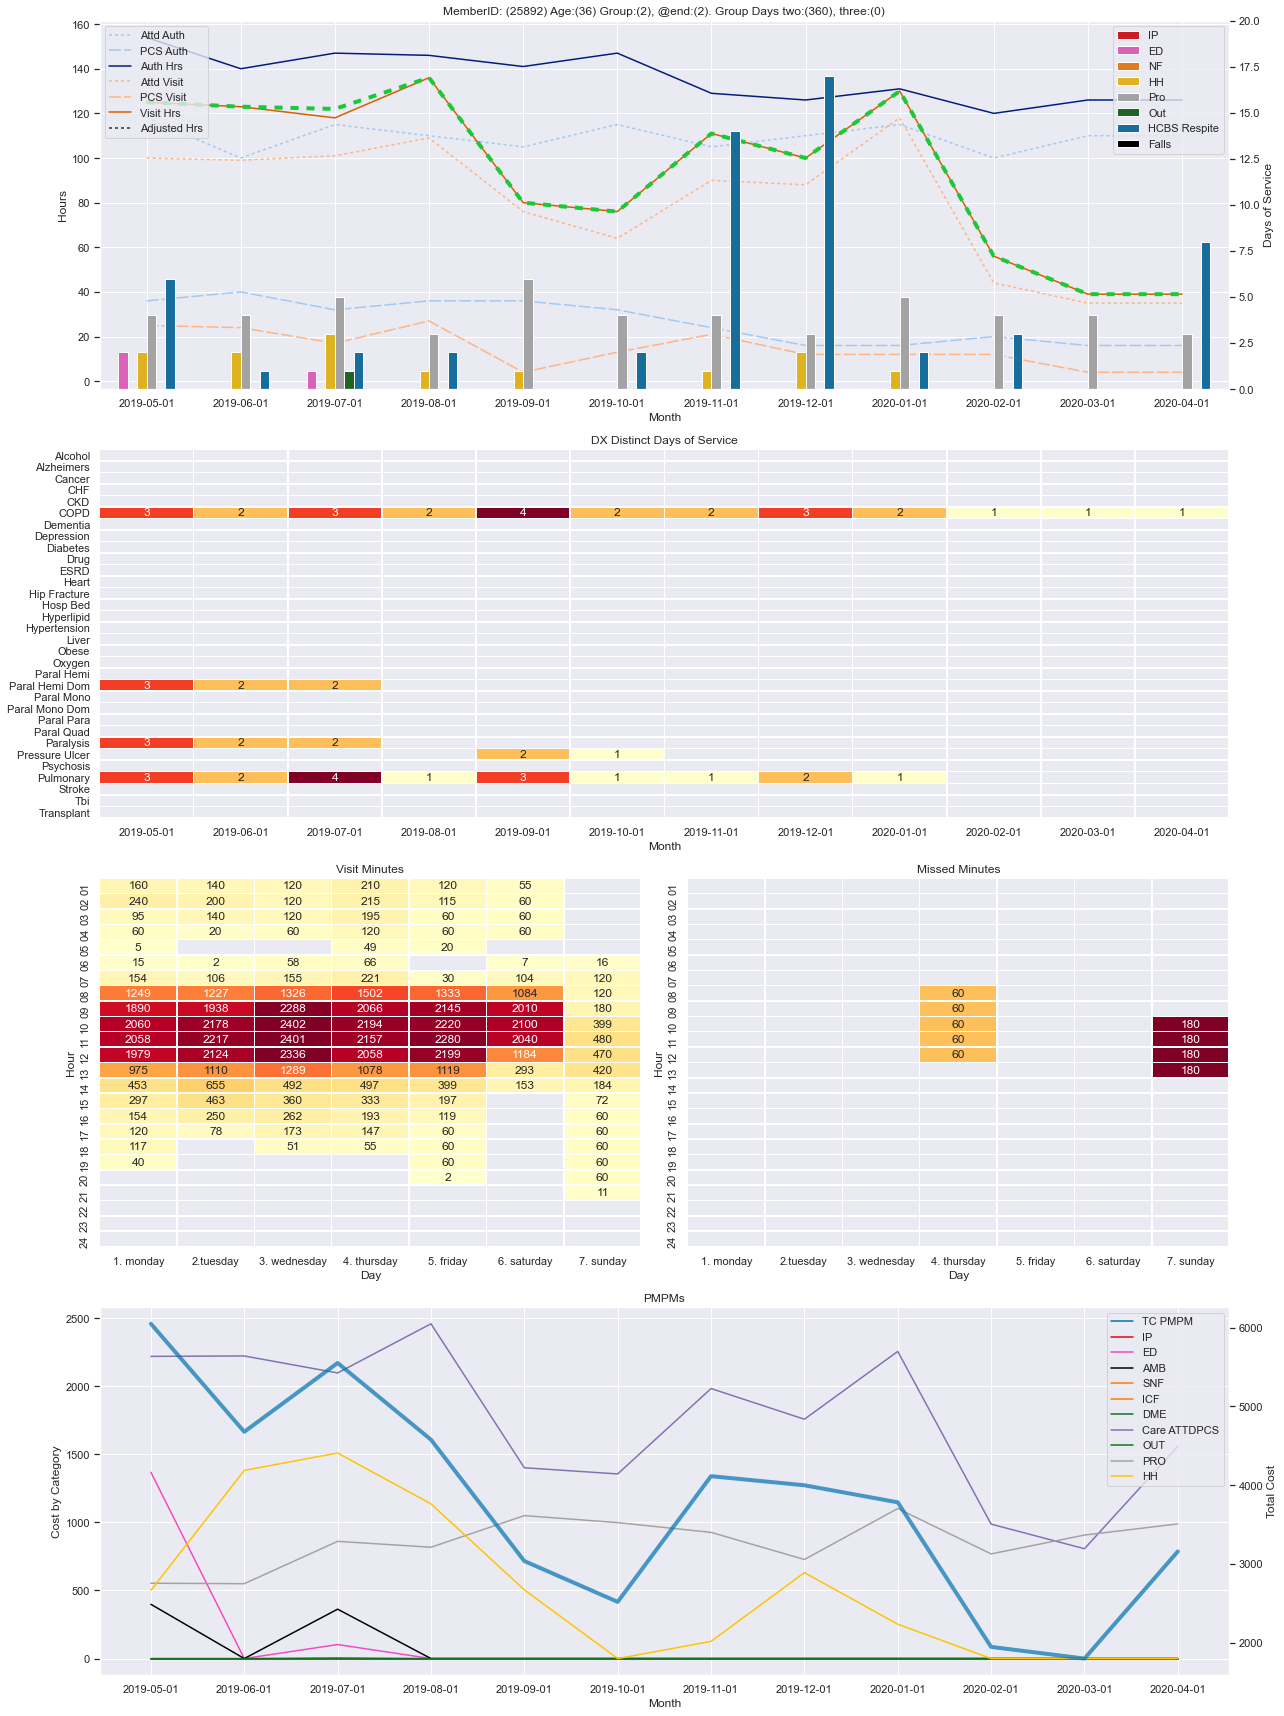

In [74]:
def graph_member(member_id, save=True):
    # I expect to see SNS RuntimeWarnings in this block
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        warnings.simplefilter("ignore", category=UserWarning)
        if not save:
            print('Graphing: ', member_id)
        #     member_id = 2788
        #     print(f'Graphing {i+1}/{n}')
        member = ds_tall_wide.query('member_id == @member_id')
        [age_yr, grp, grp_end, grp_2_days, grp_3_days] = member[['age_yr', 'grp_yr', 'grp_end_yr', 'grp_2_days_yr', 'grp_3_days_yr']].values[0]
        title = f'MemberID: ({member_id}) Age:({age_yr}) Group:({grp}), @end:({grp_end}). Group Days two:({grp_2_days}), three:({grp_3_days})'

        if  member[['care_cls_pmpm_yr', 'care_aclf_pmpm_yr', 'care_alfgc_pmpm_yr', 'care_adult_day_pmpm_yr']].sum().sum() > 0:
            care_cls_pmpm, care_aclf_pmpm, care_alfgc_pmpm, care_adult_day_pmpm = member[['care_cls_pmpm_yr', 'care_aclf_pmpm_yr', 'care_alfgc_pmpm_yr', 'care_adult_day_pmpm_yr']].sum()
            title += f'\nCare PMPMs CLS(${care_cls_pmpm}), ACLF(${care_aclf_pmpm}), ALFGC(${care_alfgc_pmpm}), Adult Day(${care_adult_day_pmpm})'

        mems = tmelt.query("member_id == @member_id")
        lines_df = mems.query("variable in @hrs_cols")

        lines_df = lines_df.rename(columns={"value": "Hours", "variable": 'Type of Hours'})
        lines_df['Type of Hours'] = lines_df['Type of Hours'].map({
            'appropriate_hrs': 'Adjusted Hrs',
            'auth_attd_pcs_hrs': 'Auth Hrs',
            'attd_pcs_visit_hrs': 'Visit Hrs',
            'pcs_visit_hrs': 'PCS Visit',
            'auth_pcs_hrs': 'PCS Auth',
            'auth_attd_hrs': 'Attd Auth',
            'attd_visit_hrs': 'Attd Visit',
        })

        lines_df.Hours = lines_df.Hours.astype(int)
        bars_df = mems.query("variable not in ['auth_attd_pcs_hrs', 'attd_pcs_visit_hrs']")
        bars_df = bars_df.rename(columns={"value": "Days of Service", 'variable': 'Event'})
        bars_df.Event = bars_df.Event.map({
            'ed_ddos': 'ED',
            'ip_ddos': 'IP',
            'nf_ddos': 'NF',
        #         'snf_ddos': 'SNF',
        #         'icf_ddos': 'ICF',
            'hh_ddos': 'HH',
            'pro_ddos': 'Pro',
            'out_ddos': 'Out',
            'hcbs_respite_ddos': 'HCBS Respite',
            'fall_ddos': 'Falls'
        })

        bar_palette = {
            'IP': "#E8000B",
            'ED': "#F14CC1",
            'NF': "#FF7C00",
            'HH': "#FFC400",
            'Pro': "#A3A3A3",
            'Out': "#12711C",
            'HCBS Respite': "#0173B2",
            'Falls': '#000000'
        }
        bar_hue_order = ['IP', 'ED', 'NF', 'HH', 'Pro', 'Out', 'HCBS Respite', 'Falls']

        line_palette = {
            'Adjusted Hrs': "#1AC938",
            'Auth Hrs': "#001C7F",
            'Visit Hrs': "#D55E00",
            'PCS Visit': "#FFB482",
            'PCS Auth': "#A1C9F4",
            'Attd Visit': "#FFB482",
            'Attd Auth': "#A1C9F4",
        }
        line_dash = {
            'Adjusted Hrs': (2, 2),
            'Auth Hrs': "",
            'Visit Hrs': "",
            'PCS Visit': (8, 2),
            'PCS Auth': (8, 2),
            'Attd Visit': (2,2),
            'Attd Auth': (2,2),   
        }

        line_style_order = ['Adjusted Hrs', 'Auth Hrs', 'Visit Hrs', 'PCS Visit', 'PCS Auth', 'Attd Visit', 'Attd Auth' ]



        #     fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(18, 35))

        fig = plt.figure(tight_layout=True, figsize=(18, 24))
        gs = gridspec.GridSpec(4, 2)

        #####
        # Hrs
        #####
        ax = fig.add_subplot(gs[0, :])
        #     ax = axes[0]
        x = 'Month'
        ax = sns.lineplot(ax=ax, x=x, y='Hours', hue='Type of Hours', style='Type of Hours', palette=line_palette, dashes=line_dash, style_order=line_style_order, data=lines_df.loc[lines_df['Type of Hours'] != 'Adjusted Hrs'])
        ax = sns.lineplot(ax=ax, x=x, y='Hours', legend=False, hue='Type of Hours', style='Type of Hours', palette=line_palette, dashes=line_dash, style_order=line_style_order, data=lines_df.loc[lines_df['Type of Hours'] == 'Adjusted Hrs'], linewidth=4)
        ax.legend(loc='upper left')

        ax.set(title=title)
        # ax.set(ylim=(0, 300))

        #####
        # DDOS Spend Type
        #####
        ax2 = ax.twinx()
        pal = sns.color_palette("Set3", 9)
        ax2 = sns.barplot(x=x, y='Days of Service', hue='Event', hue_order=bar_hue_order, palette=bar_palette, ax=ax2, data=bars_df)
        ax2.legend(loc='upper right')

        ax2.set(ylim=(0, 20))
        ax2.grid(False)




        #####
        # DX DDOS
        #####

        #     ax = axes[1]
        ax = fig.add_subplot(gs[1, :])
        ax.set(title="DX Distinct Days of Service")
        grid = member[['bom'] + dx_cols].set_index('bom').transpose().sort_index()
        grid.index = grid.index.map({
             'alzh_ddos': 'Alzheimers',
             'paralysis_ddos': 'Paralysis',
             'dementia_ddos': 'Dementia',
             'stroke_ddos': 'Stroke',
             'psychosis_ddos': 'Psychosis',
             'tbi_ddos': 'Tbi',
             'obese_ddos': 'Obese',
             'oxygen_ddos': 'Oxygen',
             'hosp_bed_ddos': 'Hosp Bed',
             'pressure_ulcer_ddos': 'Pressure Ulcer',
             'paral_mono_ddos': 'Paral Mono',
             'paral_mono_dom_ddos': 'Paral Mono Dom',
             'paral_hemi_ddos': 'Paral Hemi',
             'paral_hemi_dom_ddos': 'Paral Hemi Dom',
             'paral_para_ddos': 'Paral Para',
             'paral_quad_ddos': 'Paral Quad',

             'pulmonar_ddos': 'Pulmonary',
             'copd_ddos': 'COPD',
             'chf_ddos': 'CHF',
             'heart_ddos': 'Heart',
             'cancer_ddos': 'Cancer',
             'ckd_ddos': 'CKD',
             'esrd_ddos': 'ESRD',
             'hyperlipid_ddos': 'Hyperlipid',
             'diab_ddos': 'Diabetes',
             'hypertension_ddos': 'Hypertension',
             'transplant_ddos': 'Transplant',
             'liver_ddos': 'Liver',
             'depression_ddos': 'Depression',
             'drug_ddos': 'Drug',
             'alcohol_ddos': 'Alcohol',
             'hippfract_ddos': 'Hip Fracture' 
        })
        grid.iloc[grid == 0] = np.nan
        sns.heatmap(grid, ax=ax,  yticklabels=True, xticklabels=True,robust=True, annot=True, linewidths=.5, cmap="YlOrRd", cbar=False, vmin=1)
        ax.set_xlabel("Month")

        #####
        # PMPMs
        #####
        pmpms = mems.query('variable in @cost_cols')

        pmpms = pmpms.rename(columns={"value": "Dollars"})
        pmpms['variable'] = pmpms['variable'].map({
             'pmpm': 'TC PMPM',
             'dme_pmpm': 'DME',
             'care_attdpcs_pmpm': 'Care ATTDPCS',
             'amb_pmpm': 'AMB',
             'ed_pmpm': 'ED',
             'ip_pmpm': 'IP',
             'snf_pmpm': 'SNF',
             'icf_pmpm': 'ICF',
             'out_pmpm': 'OUT',
             'pro_pmpm': 'PRO',
             'hh_pmpm': 'HH'
        })

        pmpm_palette = {
           'TC PMPM': "#0173B2",
           'DME': "#12711C",
           'Care ATTDPCS': "#8172B3",
           'AMB': '#000000',
           'ED': "#F14CC1",
           'IP': "#E8000B",
           'SNF': "#FF7C00",
           'ICF': "#FF7C00",
           'OUT': "#12711C",
           'PRO': "#A3A3A3",
           'HH': "#FFC400",
        }
        pmpm_order = [
            'TC PMPM',
            'IP',
            'ED',
            'AMB',
            'SNF',
            'ICF',
            'DME',
            'Care ATTDPCS',
            'OUT',
            'PRO',
            'HH'
        ]

        ax = fig.add_subplot(gs[3, :])
        #     ax = axes[2]
        ax = sns.lineplot(ax=ax, x=x, y='Dollars', hue='variable', palette=pmpm_palette, hue_order=pmpm_order, data=pmpms.query('variable != "TC PMPM"'))
        ax.set(title="PMPMs")
        ax.set_ylabel("Cost by Category")
        ax.legend(loc='upper right')

        ax2 = ax.twinx()
        ax2 = sns.lineplot(ax=ax2, x=x, y='Dollars', linewidth=4, alpha=.7, hue='variable', palette=pmpm_palette, hue_order=pmpm_order, legend=False, data=pmpms.query('variable == "TC PMPM"'))
        ax2.set_ylabel("Total Cost")
        ax2.grid(False)

        #####
        # Schedule
        #####
        grp = 'all'
        mem = vap.query('member_id == @member_id and procedure_code == @grp')


        mem = mem.replace(0, np.nan)

        visit_grid = mem[['good_day'] + visit_hrs].set_index('good_day')
        visit_grid = visit_grid.sort_index().transpose()
        visit_grid.index = visit_grid.index.map(lambda x: x[4:])

        missed_grid = mem[['good_day'] + missed_hrs].set_index('good_day')
        missed_grid = missed_grid.sort_index().transpose()
        missed_grid.index = missed_grid.index.map(lambda x: x[4:])


        ax = fig.add_subplot(gs[2, 0])
        #     ax = axes[3]
        ax = sns.heatmap(visit_grid, ax=ax, robust=True, annot=True, linewidths=.5, cmap="YlOrRd", vmin=1, cbar=False, fmt='g') #  ,
        ax.set(title=f'Visit Minutes')
        ax.set_xlabel('Day')
        ax.set_ylabel('Hour')

        #     ax = axes[4]
        ax = fig.add_subplot(gs[2, 1])
        ax = sns.heatmap(missed_grid, ax=ax, robust=True, annot=True, linewidths=.5, cmap="YlOrRd", vmin=1, cbar=False, fmt='g') #  ,
        ax.set(title=f'Missed Minutes')
        ax.set_xlabel('Day')
        ax.set_ylabel('Hour')


    #     plt.tight_layout()
    if save:
        plt.savefig(f'outputs/anthem_20201012/{member_id}_ds.png')
    #         plt.savefig(f'outputs/{member_id}_w_ds.png', bbox_inches = 'tight', pad_inches = 0)
        plt.close(fig)


# graph_member(random.choice(ds_tall_wide.member_id.unique()), save=False)
graph_member(25892, save=False)

In [20]:
ds_tall_wide.loc[ds_tall_wide.member_id == 22169].head()

,id,ds_batch_id,member_id,period,forward_period,bom,appropriate_hrs,auth_attd_hrs,auth_pcs_hrs,auth_attd_pcs_hrs,attd_visit_hrs,pcs_visit_hrs,attd_pcs_visit_hrs,ed_ddos,ip_ddos,nf_ddos,snf_ddos,icf_ddos,hh_ddos,pro_ddos,out_ddos,hcbs_respite_ddos,fall_ddos,pmpm,dme_pmpm,care_attdpcs_pmpm,amb_pmpm,ed_pmpm,ip_pmpm,snf_pmpm,icf_pmpm,out_pmpm,pro_pmpm,hh_pmpm,alzh_ddos,paralysis_ddos,dementia_ddos,stroke_ddos,psychosis_ddos,tbi_ddos,obese_ddos,oxygen_ddos,hosp_bed_ddos,pressure_ulcer_ddos,paral_mono_ddos,paral_mono_dom_ddos,paral_hemi_ddos,paral_hemi_dom_ddos,paral_para_ddos,paral_quad_ddos,pulmonar_ddos,copd_ddos,chf_ddos,heart_ddos,cancer_ddos,ckd_ddos,esrd_ddos,hyperlipid_ddos,diab_ddos,hypertension_ddos,transplant_ddos,liver_ddos,depression_ddos,drug_ddos,alcohol_ddos,hippfract_ddos,age_yr,care_cls_pmpm_yr,care_aclf_pmpm_yr,care_alfgc_pmpm_yr,care_adult_day_pmpm_yr,grp_end_yr,grp_yr,grp_2_days_yr,grp_3_days_yr,lob_yr,lob_end_yr,lob_1_days_yr,lob_2_days_yr,lob_3_days_yr
280,60824,21,22169,-4,8,2020-02-01,18,0,35,35,0,18,18,1,0,0,0,0,3,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,0,3.0,NaN,NaN,NaN,NaN,55,None,None,None,NaN,2,2,141,0,1,1,141,0,0
281,60825,21,22169,-3,9,2020-03-01,0,0,109,109,0,0,0,0,0,5,0,5,0,8,1,0,0,9713.78,64.44,0.00,0.0,0.0,0.0,0.0,5140.46,7.01,619.67,0.00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,0,4.0,1.0,NaN,NaN,NaN,55,None,None,None,NaN,2,2,141,0,1,1,141,0,0
282,60826,21,22169,-2,10,2020-04-01,105,0,105,105,0,35,35,0,0,1,0,1,4,5,0,0,0,5533.28,0.00,974.71,0.0,0.0,0.0,0.0,197.71,0.00,486.28,735.46,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,5.0,0,5.0,NaN,NaN,NaN,NaN,55,None,None,None,NaN,2,2,141,0,1,1,141,0,0
283,60827,21,22169,-1,11,2020-05-01,95,0,109,109,0,95,95,0,0,0,0,0,2,2,0,0,0,5266.16,102.68,2610.16,0.0,0.0,0.0,0.0,0.00,0.00,90.07,157.73,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,2.0,0,3.0,NaN,NaN,NaN,NaN,55,None,None,None,NaN,2,2,141,0,1,1,141,0,0


In [23]:
ds_tall_wide.dtypes

id                int64
ds_batch_id       int64
member_id         int64
period            int64
forward_period    int64
                  ...  
lob_yr            int64
lob_end_yr        int64
lob_1_days_yr     int64
lob_2_days_yr     int64
lob_3_days_yr     int64
Length: 80, dtype: object

In [21]:

# graph_member(random.choice(ds_tall_wide.member_id.unique()), save=False)
# graph_member(2788, save=True)
# graph_member(270, save=True)
# graph_member(988, save=True)

  0%|          | 0/157 [00:00<?, ?it/s]


TypeError: Neither the `x` nor `y` variable appears to be numeric.

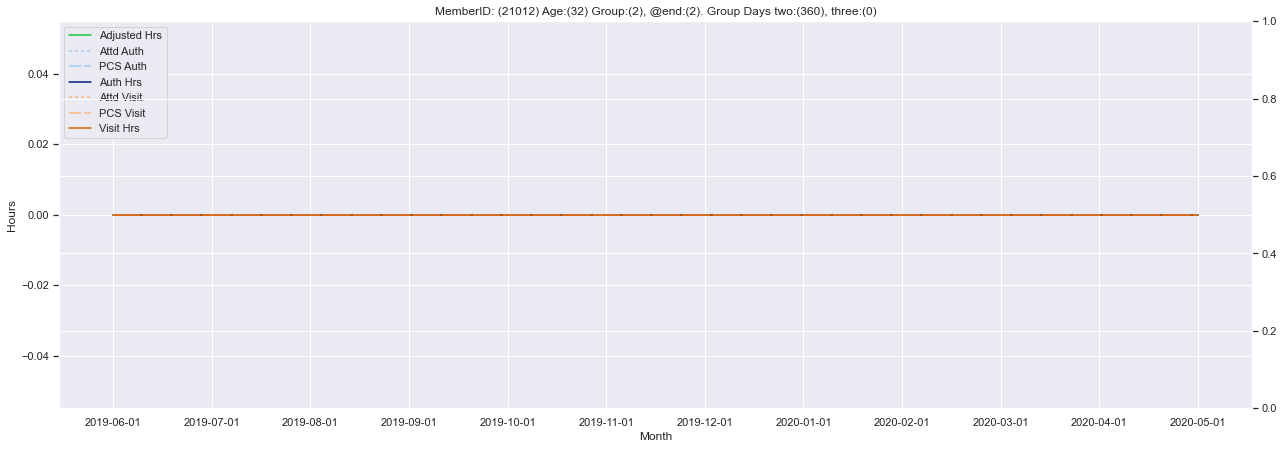

In [22]:
# run_save_all_members = True
# if run_save_all_members:
#     with Pool() as pool:
#         pool.map(graph_member, sorted(ds_tall_wide.member_id.unique()))
for member_id in tqdm(sorted(ds_tall_wide.member_id.unique())):
    graph_member(member_id)

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

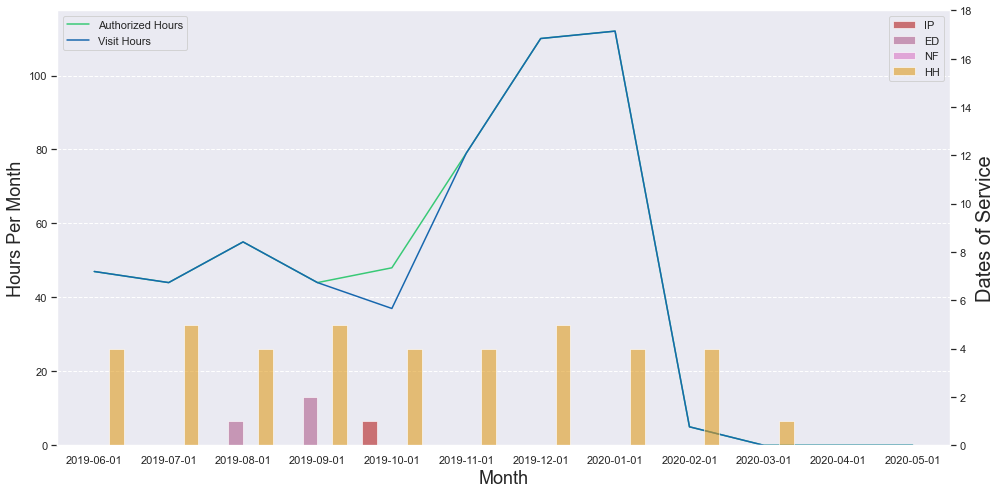

In [23]:
def graph_member_small(member_id, save=True):
#     print(f'Graphing {i+1}/{n}')
    member = ds_tall_wide.query('member_id == @member_id')
    [age_yr, grp, grp_end, grp_2_days, grp_3_days] = member[['age_yr', 'grp_yr', 'grp_end_yr', 'grp_2_days_yr', 'grp_3_days_yr']].values[0]
    title = f'MemberID: ({member_id}) Age:({age_yr}) Group:({grp}), @end:({grp_end}). Group Days two:({grp_2_days}), three:({grp_3_days})'

    if  member[['care_cls_pmpm_yr', 'care_aclf_pmpm_yr', 'care_alfgc_pmpm_yr', 'care_adult_day_pmpm_yr']].sum().sum() > 0:
        care_cls_pmpm, care_aclf_pmpm, care_alfgc_pmpm, care_adult_day_pmpm = member[['care_cls_pmpm_yr', 'care_aclf_pmpm_yr', 'care_alfgc_pmpm_yr', 'care_adult_day_pmpm_yr']].sum()
        title += f'\nCare PMPMs CLS(${care_cls_pmpm}), ACLF(${care_aclf_pmpm}), ALFGC(${care_alfgc_pmpm}), Adult Day(${care_adult_day_pmpm})'

    h_cols = [
#         'appropriate_hrs',
        'auth_attd_pcs_hrs',
        'attd_pcs_visit_hrs',
#         'pcs_visit_hrs',
#         'auth_pcs_hrs',
#         'auth_attd_hrs',
#         'attd_visit_hrs',
    ]
    
    mems = tmelt.query("member_id == @member_id")
    lines_df = mems.query("variable in @h_cols")
    auth = 'Authorized Hours'
    visit = 'Visit Hours'

    lines_df = lines_df.rename(columns={"value": "Hours", "variable": 'Type of Hours'})
    lines_df['Type of Hours'] = lines_df['Type of Hours'].map({
        'appropriate_hrs': 'Appr Hrs',
        'auth_attd_pcs_hrs': auth,
        'attd_pcs_visit_hrs': visit,
        'pcs_visit_hrs': 'PCS Visit',
        'auth_pcs_hrs': 'PCS Auth',
        'auth_attd_hrs': 'Attd Auth',
        'attd_visit_hrs': 'Attd Visit',
    })


    excluded_bars = ['auth_attd_pcs_hrs', 'attd_pcs_visit_hrs', 'pro_ddos', 'out_ddos', 'falls_ddos', 'hcbs_respite_ddos']
    bars_df = mems.query("variable not in @excluded_bars")
    bars_df = bars_df.rename(columns={"value": "Days of Service", 'variable': 'Event'})
    bars_df.Event = bars_df.Event.map({
        'ed_ddos': 'ED',
        'ip_ddos': 'IP',
        'nf_ddos': 'NF',
    #         'snf_ddos': 'SNF',
    #         'icf_ddos': 'ICF',
        'hh_ddos': 'HH',
        'pro_ddos': 'Pro',
        'out_ddos': 'Out',
        'hcbs_respite_ddos': 'HCBS Respite',
        'fall_ddos': 'Falls'
    })


    bar_palette = {
        'IP': "#CC0606",
        'ED': "#BC5090",
        'NF': "#EB67D0",
        'HH': "#FFA600",
#         'HCBS Respite': "#0173B2",
#         'Pro': "#A3A3A3",
#         'Out': "#12711C",
#         'Falls': '#000000'
    }
    bar_hue_order = ['IP',
                     'ED',
                     'NF',
                     'HH',
#                      'HCBS Respite',
#                      'Pro',
#                      'Out',
#                      'Falls'
                    ]

    line_palette = {
#         'Appr Hrs': "#1AC938",
        auth: "#38C976",
        visit: "#1767AE",
#         'PCS Visit': "#FFB482",
#         'PCS Auth': "#A1C9F4",
#         'Attd Visit': "#FFB482",
#         'Attd Auth': "#A1C9F4",
    }
    line_dash = {
#         'Appr Hrs': "",
        auth: "",
        visit: "",
#         'PCS Visit': (8, 2),
#         'PCS Auth': (8, 2),
#         'Attd Visit': (2,2),
#         'Attd Auth': (2,2),   
    }
    
    line_style_order = [
#         'Appr Hrs',
        auth,
        visit,
#         'PCS Visit',
#         'PCS Auth',
#         'Attd Visit',
#         'Attd Auth'
    ]


    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
    
    #####
    # Hrs
    #####
    ax = axes
    x = 'Month'
    ax = sns.lineplot(ax=ax, x=x, y='Hours', hue='Type of Hours', style='Type of Hours', palette=line_palette, dashes=line_dash, style_order=line_style_order, data=lines_df)
    ax.set_ylabel('Hours Per Month')
    ax.legend(loc='upper left')
    ax.grid(False)
    ax.grid(axis='y', linestyle='--')
    ax.set_ylim(bottom=0)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)


#     ax.set(title=title)
    
    #####
    # DDOS Spend Type
    #####
    ax2 = ax.twinx()
    pal = sns.color_palette("Set3", 9)
    ax2 = sns.barplot(x=x, y='Days of Service', hue='Event', alpha=.6, hue_order=bar_hue_order, palette=bar_palette, ax=ax2, data=bars_df)
    ax2.legend(loc='upper right')
    ax2.set_ylabel('Dates of Service')

    ax2.set(ylim=(0, 18))
    ax2.grid(False)
    
    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    if save:
        plt.savefig(f'outputs/{member_id}_small.png', bbox_inches = 'tight', pad_inches = 0)
#     plt.savefig('small.png')
        plt.close(fig)
    
graph_member_small(random.choice(ds_tall_wide.member_id.unique()), save=False)

In [ ]:
smalls = [21013
, 21403
, 22162
, 22257
, 22580
, 22665
, 23052
, 23144
, 23107
, 27654
, 27836
]

In [ ]:
for member_id in tqdm(smalls):
# for member_id in tqdm(sorted(ds_tall_wide.member_id.unique())):
    graph_member_small(member_id)